# ConvLSTM Implementation

To evaluate this ConvLSTM implementation, we will begin by generating a dummy dataset using MNIST. We'll introduce an additional dimension to simulate a video frame sequence, where the same digit is repeated across 10 frames. Each frame will have random noise added to it, allowing us to test whether the neural network can effectively extract temporal features despite this variability.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import random
import matplotlib.pyplot as pl

In [2]:
def set_seed(seed):
    # Set seed for random, numpy, and torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If using GPU, set the seed for CUDA as well
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU environments

    # Ensure reproducibility for certain PyTorch operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
train_set = datasets.MNIST(root='~/.pytorch/MNIST_data/', download=True, train=True)
test_set = datasets.MNIST(root='~/.pytorch/MNIST_data/', download=True, train=False)

# Define sequence size
seq_size = 10

#define height and width
mnist_h = test_set.data.shape[2]
mnist_w = train_set.data.shape[1]

# Print the shapes of the new datasets
print(f"Train data shape: {train_set.data.shape}")
print(f"Test data shape: {test_set.data.shape}")

# Expand MNIST data to simulate video sequences
train_mnist = train_set.data.unsqueeze(1).repeat(1, seq_size, 1, 1)
test_mnist = test_set.data.unsqueeze(1).repeat(1, seq_size, 1, 1)

# Print the shapes of the new datasets
print(f"Train temporal data shape: {train_mnist.shape}")
print(f"Test temporal data shape: {test_mnist.shape}")

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 883kB/s] 


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 63.4kB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.34MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Train data shape: torch.Size([60000, 28, 28])
Test data shape: torch.Size([10000, 28, 28])
Train temporal data shape: torch.Size([60000, 10, 28, 28])
Test temporal data shape: torch.Size([10000, 10, 28, 28])


In [4]:
noise_value = 400

# Function to add random noise to dataset and normalize
def add_noise_and_normalize(data, seq_size, noise_value):
    # Generate random noise frames
    noise = torch.FloatTensor(data.shape[0], seq_size, data.shape[1], data.shape[2]).uniform_(-noise_value, noise_value)

    # Expand original data to simulate sequences and add noise
    data_expanded = data.unsqueeze(1).repeat(1, seq_size, 1, 1).float()
    noisy_data = torch.clamp(data_expanded + noise, min=0, max=255)

    # Normalize to range [0, 1]
    noisy_data -= noisy_data.min()
    noisy_data /= noisy_data.max()

    return noisy_data

# Apply the function to train and test datasets
train_noisy_frames = add_noise_and_normalize(train_set.data, seq_size, noise_value)
test_noisy_frames = add_noise_and_normalize(test_set.data, seq_size, noise_value)

# Check shapes
print(f"Train noisy frames shape: {train_noisy_frames.shape}")
print(f"Test noisy frames shape: {test_noisy_frames.shape}")

Train noisy frames shape: torch.Size([60000, 10, 28, 28])
Test noisy frames shape: torch.Size([10000, 10, 28, 28])


In [5]:
!nvidia-smi

Sun Oct 27 05:32:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Visualizing a Training Sequence of Noisy Frames

We will display 10 images from a previously generated video sequence to illustrate the effects of noise. As you can see, the added noise makes it nearly impossible to discern the underlying digit in any single frame. However, this is where the ConvLSTM model comes into play—it may be capable of leveraging temporal patterns across the entire sequence to accurately identify the digit hidden beneath the noise.

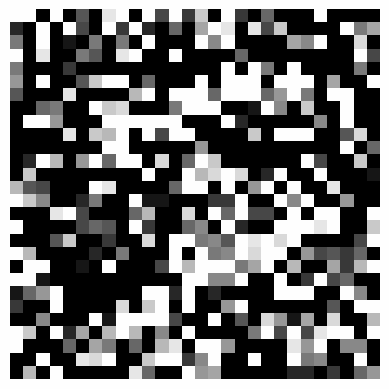

In [6]:
import torch
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Adjusted to avoid deprecation warning
import numpy as np

# Create function to generate GIF
def create_gif_from_tensor(tensor, filename='output.gif', duration=0.1):
    """
    Creates a GIF from a tensor of shape (num_samples, seq_size, H, W).
    """
    images = []
    seq_size = tensor.shape[1]

    for i in range(seq_size):
        # Convert each frame to numpy and plot using matplotlib
        frame = tensor[0, i].numpy()  # Taking the first sample from the batch
        plt.imshow(frame, cmap='gray')  # Use 'gray' for grayscale images
        plt.axis('off')

        # Save the frame to a temporary file
        plt.savefig(f"frame_{i}.png", bbox_inches='tight')
        plt.close()

        # Read the saved file and append to images list
        images.append(imageio.imread(f"frame_{i}.png"))

    # Create a gif from the images with infinite loop
    imageio.mimsave(filename, images, duration=duration, loop=0)  # 'loop=0' makes the GIF loop infinitely

# Create GIF from train dataset
create_gif_from_tensor(train_noisy_frames, filename='train_noisy_frames.gif')

# Display the GIF in the notebook
from IPython.display import Image
Image(filename='train_noisy_frames.gif')


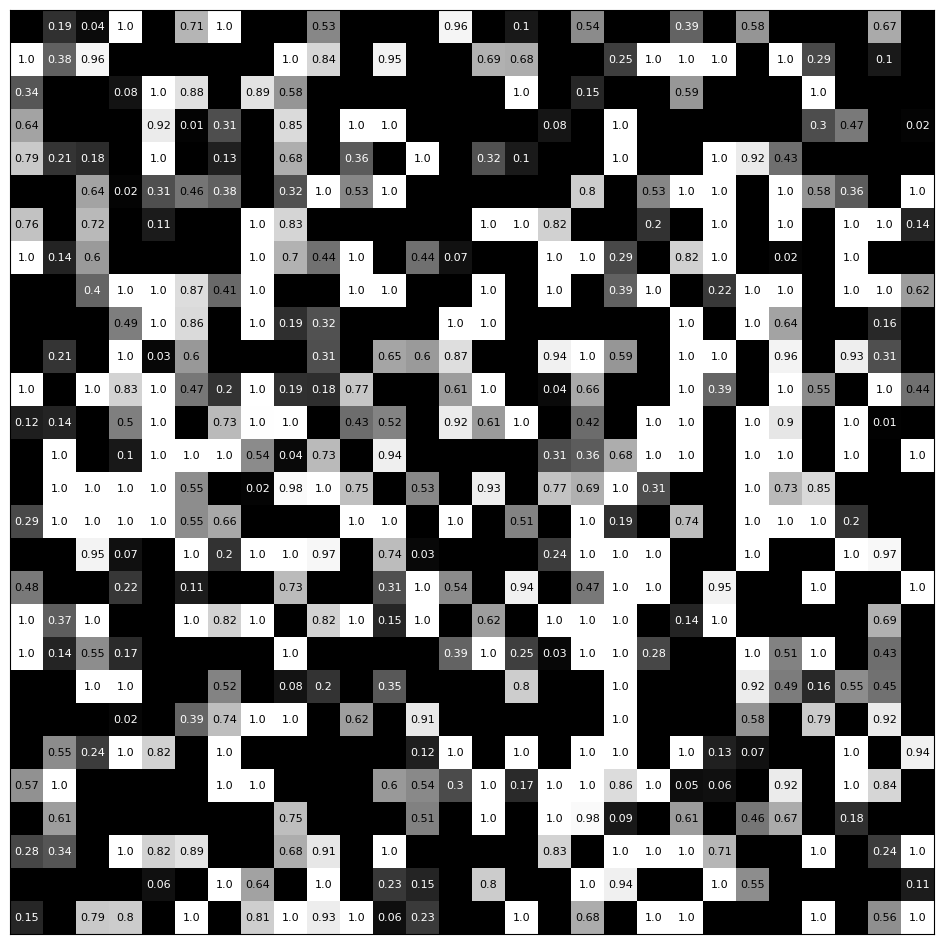

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize an image with pixel values annotated
def visualize_with_annotations(image, figsize=(12, 12), threshold_divisor=2.5):
    # Prepare the image and set up the plot
    img = np.squeeze(image).numpy()
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img, cmap='gray')

    # Set up threshold for text color
    thresh = img.max() / threshold_divisor
    width, height = img.shape

    # Annotate pixel values on the image
    for x in range(width):
        for y in range(height):
            val = round(img[x, y], 2)
            if val != 0:  # Only annotate non-zero values
                ax.text(y, x, str(val),
                        ha='center', va='center',
                        color='white' if img[x, y] < thresh else 'black',
                        fontsize=8)

    # Hide axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Visualize a single frame from the training sequence with annotations
visualize_with_annotations(train_noisy_frames[2, 0])


# Define the ConvLSTM

In [8]:
import torch
import torch.nn as nn

input_tensor = torch.randn(1, 3, 10)  # e.g., batch size = 1, 3 input channels, length = 10

# Define the Conv1d layer
conv1d_layer = nn.Conv1d(in_channels=3, out_channels=5, kernel_size=3, padding=0, stride=1)

# Apply convolution
output_tensor = conv1d_layer(input_tensor)

print("Input shape:", input_tensor.shape)       # torch.Size([1, 3, 10])
print("Output shape:", output_tensor.shape)     # torch.Size([1, 5, 10])

Input shape: torch.Size([1, 3, 10])
Output shape: torch.Size([1, 5, 8])


In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias=True):
        """
        Initialize a ConvLSTM cell.

        Parameters:
        ----------
        input_size : tuple(int, int)
            Height and width of the input tensor as (height, width).
        input_dim : int
            Number of channels of the input tensor.
        hidden_dim : int
            Number of channels of the hidden state.
        kernel_size : tuple(int, int)
            Size of the convolutional kernel.
        bias : bool, optional
            Whether to add bias to the convolutional layers. Default is True.
        """
        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias = bias

        # Define the convolutional layer for input-to-state and state-to-state transformations
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=kernel_size,
            padding=self.padding,
            bias=bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        # Concatenate along the channel dimension
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)

        # Apply activations
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        # Compute the next cell and hidden states
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        device = self.conv.weight.device
        return (torch.zeros(batch_size, self.hidden_dim, self.height, self.width, device=device),
                torch.zeros(batch_size, self.hidden_dim, self.height, self.width, device=device))


class ConvLSTM(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        """
        Initialize the ConvLSTM model.

        Parameters:
        ----------
        input_size : tuple(int, int)
            Height and width of the input tensor as (height, width).
        input_dim : int
            Number of channels of the input tensor.
        hidden_dim : int or list
            Number of channels of the hidden state for each layer. If int, same number of channels is used for all layers.
        kernel_size : tuple or list
            Size of the convolutional kernel for each layer. If tuple, same kernel size is used for all layers.
        num_layers : int
            Number of ConvLSTM layers.
        batch_first : bool, optional
            Whether the input/output tensors have batch size as the first dimension. Default is False.
        bias : bool, optional
            Whether to add bias to the convolutional layers. Default is True.
        return_all_layers : bool, optional
            Whether to return all layers' output or only the last layer. Default is False.
        """
        super(ConvLSTM, self).__init__()

        # Ensure kernel size consistency
        self._check_kernel_size_consistency(kernel_size)

        # Extend parameters for multiple layers if necessary
        self.hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        self.kernel_size = self._extend_for_multilayer(kernel_size, num_layers)

        if len(self.hidden_dim) != num_layers or len(self.kernel_size) != num_layers:
            raise ValueError("Inconsistent list length between hidden_dim and kernel_size.")

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        # Create a list of ConvLSTMCell layers
        self.cell_list = nn.ModuleList([
            ConvLSTMCell(input_size=(self.height, self.width),
                         input_dim=input_dim if i == 0 else self.hidden_dim[i - 1],
                         hidden_dim=self.hidden_dim[i],
                         kernel_size=self.kernel_size[i],
                         bias=self.bias)
            for i in range(num_layers)
        ])

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters:
        ----------
        input_tensor : torch.Tensor
            Input tensor of shape (batch, time, channels, height, width) if batch_first is True,
            else (time, batch, channels, height, width).
        hidden_state : list of tuples, optional
            Initial hidden states for each layer. Default is None.

        Returns:
        -------
        layer_output_list, last_state_list
        """
        if not self.batch_first:
            # Convert to (batch, time, channels, height, width)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        batch_size = input_tensor.size(0)
        seq_len = input_tensor.size(1)

        # Initialize hidden states if not provided
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size)

        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor

        # Iterate over each ConvLSTM layer
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []

            # Iterate over the sequence
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            # Collect outputs for the layer
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        # Return either all layers or just the last layer
        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        return [cell.init_hidden(batch_size) for cell in self.cell_list]

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all(isinstance(k, tuple) for k in kernel_size))):
            raise ValueError("`kernel_size` must be a tuple or a list of tuples.")

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        return param if isinstance(param, list) else [param] * num_layers


# Network architecture

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_channels = 8

        # QRNN3D layer instead of ConvLSTM
        self.conv_lstm = ConvLSTM(
            input_size=(mnist_h, mnist_w),
            input_dim=1,
            hidden_dim=[hidden_channels],
            kernel_size=(3, 3),
            num_layers=1,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )

        self.bn1 = nn.BatchNorm2d(hidden_channels)

        # Convolutional, dropout, and fully connected layers
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels * 2, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(hidden_channels *2)

        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(in_features=hidden_channels * 2 * 5 * 5, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=10)

    def forward(self, x):
        # Pass through QRNN
        x = x.unsqueeze(2)  # Ensure data shape matches model input expectations

        _, last_state = self.conv_lstm(x)
        h = last_state[0][0]  # Extract the hidden state (h) from the last layer
        x = (self.bn1(h))

        # Apply convolutional and pooling layers
        x = F.relu(F.max_pool2d(h, 2))

        x = self.conv2(x)
        x = (self.bn2(x))

        x = F.relu(F.max_pool2d(self.conv2_drop(x), 2))

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Ensures proper flattening without hardcoding dimensions
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)  # Explicit dropout rate for better control
        x = self.fc2(x)

        # Apply log softmax for output
        return x

# Training

In [17]:
class NoisyMnist(Dataset):
    def __init__(self, train=True):
        self.ds = train_noisy_frames if train else test_noisy_frames
        self.dt = train_set.targets if train else test_set.targets

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        return self.ds[idx], self.dt[idx]

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

# Initialize the model and move to GPU if available
model = Net().cuda() if torch.cuda.is_available() else Net()

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Training parameters
n_epochs = 50
valid_loss_min = float('inf')  # Use float('inf') instead of np.Inf for consistency
noisy_mnist = NoisyMnist(train=True)


train_data_loader = DataLoader(noisy_mnist, batch_size=256, shuffle=True, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

noisy_mnist = NoisyMnist(train=False)
test_dataloader = DataLoader(noisy_mnist, batch_size=10000, shuffle=False, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

Epoch 1/50 - Training Accuracy: 80.25% - Testing Accuracy: 94.61%
Testing loss decreased (inf --> 0.175720). Saving model ...
Epoch 2/50 - Training Accuracy: 92.76% - Testing Accuracy: 95.92%
Testing loss decreased (0.175720 --> 0.123507). Saving model ...
Epoch 3/50 - Training Accuracy: 94.49% - Testing Accuracy: 96.91%
Testing loss decreased (0.123507 --> 0.097155). Saving model ...
Epoch 4/50 - Training Accuracy: 95.38% - Testing Accuracy: 97.21%
Testing loss decreased (0.097155 --> 0.083361). Saving model ...
Epoch 5/50 - Training Accuracy: 95.93% - Testing Accuracy: 97.00%
Epoch 6/50 - Training Accuracy: 96.16% - Testing Accuracy: 97.33%
Testing loss decreased (0.083361 --> 0.077540). Saving model ...
Epoch 7/50 - Training Accuracy: 96.42% - Testing Accuracy: 97.32%
Testing loss decreased (0.077540 --> 0.075505). Saving model ...
Epoch 8/50 - Training Accuracy: 96.56% - Testing Accuracy: 97.62%
Testing loss decreased (0.075505 --> 0.068454). Saving model ...
Epoch 9/50 - Training 

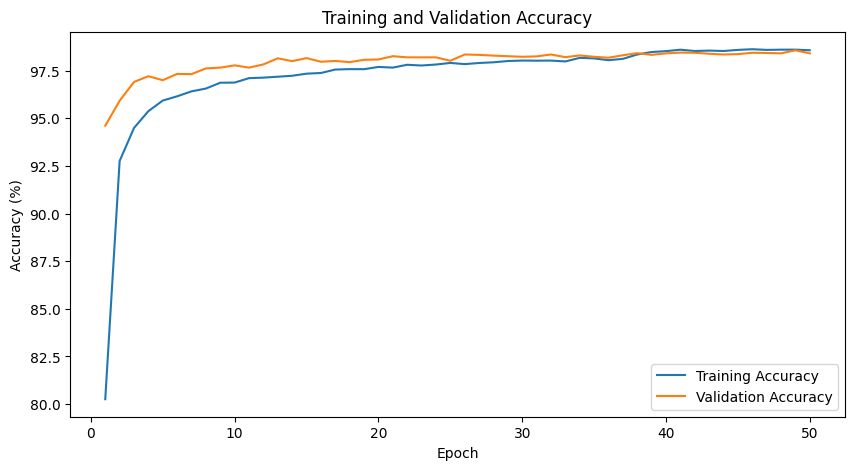

In [19]:
# Lists to record accuracy for plotting
train_accuracies = []
valid_accuracies = []
valid_loss_min = float('inf')  # Initialize min validation loss for model saving
set_seed(42)

for epoch in range(n_epochs):
    # Initialize training and validation accuracy counters
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    valid_loss = 0.0

    # Training Phase
    model.train()
    for data, target in train_data_loader:
        data, target = data.cuda(), target.cuda()
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for data, target in test_dataloader:
            data, target = data.cuda(), target.cuda()
            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Accumulate validation loss
            valid_loss += loss.item() * data.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)
            valid_total += target.size(0)
            valid_correct += (predicted == target).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    valid_accuracies.append(valid_accuracy)
    average_valid_loss = valid_loss / valid_total  # Average loss per sample

    # Step the scheduler with validation loss after it is defined
    scheduler.step(average_valid_loss)

    # Log training and validation accuracy
    print(
        f'Epoch {epoch + 1}/{n_epochs} - '
        f'Training Accuracy: {train_accuracy:.2f}% - '
        f'Testing Accuracy: {valid_accuracy:.2f}%'
    )

    # Check for improvement and save the model
    if average_valid_loss < valid_loss_min:
        print(
            f'Testing loss decreased ({valid_loss_min:.6f} --> {average_valid_loss:.6f}). '
            f'Saving model ...'
        )
        torch.save(model.state_dict(), 'noisy_model.pt')
        valid_loss_min = average_valid_loss

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, n_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Testing

In [20]:

model = Net()
model.load_state_dict(torch.load('noisy_model.pt'))
model = model.cuda()

noisy_mnist = NoisyMnist(train=False)
dataloader = DataLoader(noisy_mnist, batch_size=50, shuffle=False, num_workers=2)

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data, target in dataloader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()


print(f'Testing Accuracy: {( 100 * correct / total):.2f}%')


<ipython-input-20-ab4a8aacd790>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('noisy_model.pt'))


Testing Accuracy: 98.43%
